   # TP2 : Minimisation par optimisation proximale
   
   ## Menu
   1. [Implémentation de ISTA](#ISTA) 
   2. [Acquisition comprimée](#acqui)
   3. [Minimisation de la fonction max](#max)
   4. [Complétion de matrice de faible rang](#completion)

Dans ce TP on s'intéresse à des problèmes de minimisation **non-différentiable** en utilisant la théorie des opérateurs proximaux. La plupart des algorithmes présentés ici reposent sur la méthode d'éclatement, *splitting*.

En préambule on charge les paquets suivants.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Implémentation de ISTA 
<a id="ISTA"></a>


L'algorithme Iterative Shrinkage-Thresholding Algorithm, ISTA, permet la minimisation de fonctions convexes via la technique d'éclatement. En effet si ${F = f + \lambda g}$ avec $f$ convexe et assez lisse et $g$ convexe, éventuellement non-différentiable, mais pour laquelle **on peut calculer le proximal** alors on peut mettre en place un algorithme alterné.
\begin{equation}
x_{k+1} = \operatorname{prox}_{\lambda g}^{\gamma}\lbrace x_k - \gamma \nabla f (x_k) \rbrace.
\end{equation}
On montre tout d'abord que pour $(\lambda, \gamma) \in \mathbb{R}_+^*$ on a 
\begin{equation}
\operatorname{prox}_{\lambda g}^{\gamma} = \operatorname{prox}_{g}^{\lambda \gamma}
\end{equation}

**Preuve :** 
Soit $x \in \mathbb{R}^d$. 
On a 
\begin{equation}
\begin{aligned}
\operatorname{prox}_{\lambda g}^{\gamma}(x) &= \operatorname{argmin} \lbrace \lambda g(y) + (2 \gamma)^{-1} \| y - x \|^2\rbrace \\
&= \operatorname{argmin} \lbrace g(y) + (2 \gamma \lambda)^{-1} \| y - x \|^2\rbrace \\
&= \operatorname{prox}_g^{\lambda \gamma}(x)
\end{aligned}
\end{equation}

Ci-dessous on présente l'implémentation de l'algorithme ISTA.

In [2]:
def ista(dim, prox_op_g, grad_f, fun_total, lambda_l, n_it=10):
    #    Variables d'entrée :
    #    dim : dimension du problème
    #    prox_op_g : opérateur proximal de g qui prend en entrée x et gamma
    #    grad_f : gradient de f
    #    fun_total : fonction F = f+lambda*g
    #    lambda_l : paramètre lambda dans F
    #    n_it : nombre d'itérations
    #    Variables de sortie : x, fun_iterate
    #    x : itéré final de Ista
    #    fun_iterate : suite (f(x_k))

    x = np.zeros(dim)
    grad_f_x, Lip_grad_f = grad_f(x)
    gamma = 1. / (Lip_grad_f)
    fun_iterate = []
    for it in range(n_it):
        x = prox_op_g(x - gamma * grad_f_x, lambda_l * gamma)
        fun_iterate.append(fun_total(x))
        grad_f_x, _ = grad_f(x)
        #if np.mod(it, 10) == 0:
            #print('iteration number: ', it, end="\r", flush=True)
    return x, fun_iterate


def ista_mat(dim_1, dim_2, prox_op_g, grad_f, fun_total, lambda_l, n_it=500):
    x = np.zeros((dim_1, dim_2))
    grad_f_x, Lip_grad_f = grad_f(x)
    gamma = 1. / (Lip_grad_f)
    fun_iterate = []
    for it in range(n_it):
        x = prox_op_g(x - gamma * grad_f_x, lambda_l * gamma)
        fun_iterate.append(fun_total(x))
        grad_f_x, _ = grad_f(x)
    return x, fun_iterate

# Acquisition comprimée
<a id="acqui"></a>

Le problème d'**acquistion comprimée** (le plus souvent *compressed sensing* dans la littérature) est un problème classique en traitement du signal. Il s'agit de reconstruire un signal parcimonieux $x$ (i.e dont peu de composantes sont non nulles) via une représentation basse dimensionnelle $y$. Le problème s'écrit
\begin{equation}
F(x) = \| y - Ax \|_2^2 + \|x\|_1,
\end{equation}
avec $x \in \mathbb{R}^d$ et $y \in \mathbb{R}^p$ avec $p << d$.

In [3]:
from tp2_tools import *
import warnings
warnings.filterwarnings('ignore')

lambda_l1 = 1
y, A = noisy_observations()

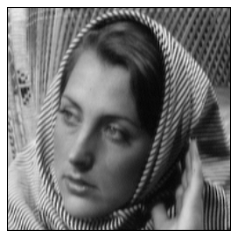

In [4]:
def show_image(x):
    fig = plt.imshow(x)
    fig.set_cmap('gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

x_true = load_image("barb.bmp",256)
show_image(x_true)

On a $f:x \ \mapsto \|A x - y \|^2$. On a bien une fonction de classe $C^1$ dont le gradient est donné par 
\begin{equation}
\forall x \in \mathbb{R}, \nabla f (x) = 2 A^T (Ax-y).
\end{equation}

La seconde propriété est très intéressante. En effet, si la fonction dont on doit calculer le proximal est séparable en ses $d$ variables on est ramené à calculer $d$ problèmes proximaux unidimensionnels. Soit 
\begin{equation}
h: \ x \mapsto \ \underset{i = 1}{\overset{d}{\sum}} h_i(x_i),
\end{equation}
avec $h_i$ convexe, sci et propre.
\begin{equation}
\begin{aligned}
\forall x \in \mathbb{R}^d, \operatorname{prox}_h^{\gamma}(x) &= \underset{y \in \mathbb{R}^d}{\operatorname{argmin}} \lbrace h(y) + (2\gamma)^{-1} \| y -x \|^2 \rbrace \\
&= \underset{y \in \mathbb{R}^d}{\operatorname{argmin}} \left\lbrace \underset{i=1}{\overset{d}{\sum}} h_i(y_i) + (2\gamma)^{-1} \underset{i=1}{\overset{d}{\sum}} (y_i - x_i)^2\right\rbrace \\
&= \underset{y \in \mathbb{R}^d}{\operatorname{argmin}} \left\lbrace \underset{i=1}{\overset{d}{\sum}} \left(h_i(y_i) + (2\gamma)^{-1} (y_i - x_i)^2\right)\right\rbrace \\
&= \left( \operatorname{prox}_{h_i}^{\gamma}(x_i) \right)_{i \in \lbrace 1,d \rbrace}
\end{aligned}
\end{equation}

$\def\prox{\mathrm{prox}}$
D'après un exercice vu en td, on a pour deux fonctions convexes $f,g : \mathbb{R}^d \to (-\infty,+\infty]$ convexes sci telles que $g$ soit continûement différentiable, on a
\begin{equation}
\partial \left( f+g\right) = \nabla g + \partial (f)
\end{equation}
On va démontrer la formule demandée dans le cas général, i.e. on a pour tout fonction $f : \mathbb{R}^d \to (-\infty,+\infty]$ convexe sci,
\begin{equation}
\prox_{f}^{\gamma}(x) \in x - \gamma \partial f( \prox_{f}^{\gamma}(x)) .
\end{equation}
En effet 
\begin{equation}
\begin{aligned}
& x^* = \underset{y \in \mathbb{R}^d}{\operatorname{argmin}} \left( f(y) +g(y)+ (2\gamma)^{-1} \| y - x \|^2 \right) \\
& \Leftrightarrow 0 \in \partial \left( f + g+(2 \gamma)^{-1} \|\cdot -x \|^2 \right)(x^*) \\
& \Leftrightarrow 0 \in \partial f(x^*) + \gamma^{-1}(x^* -x) \\
&\Leftrightarrow x^* \in x - \gamma \partial f(x^*).
\end{aligned}
\end{equation}
On a utilisé ici que la somme de sous-différentielles est la sous-différentielle de la somme *sous conditions*. Pour une preuve complète on consultera [ce cours](https://maunamn.wordpress.com/8-the-subdifferential-sum-rule/) (chapitres 6 et 8).
C'est la raison pour laquelle l'opérateur proximal proximal est parfois noté $\left(\operatorname{Id} + \gamma \partial f\right)^{-1}$. Il est bon de noter que si on note $x = x^k$ et $x^* = x^{k+1}$ on a
\begin{equation}
x^{k+1} \in x^k - \gamma \partial f(x^k).
\end{equation}
On retrouve un schéma de **descente de gradient**.
<!--
** Remarque : ** on peut prouver le résultat précédent sans utiliser la propriété de commutativité de la sous-différentielle et de la somme.
Le résultat énoncé ci-dessous est issu de *Convex Analysis and Monotone Operator Theory in Hilbert Spaces* (Bauschke & Combettes, 2011).
\begin{equation}
\forall y \in \mathbb{R}^d, f(\operatorname{prox}_f^{\gamma}(x)) - f(y) \ge \gamma^{-1} \langle y - \operatorname{prox}_f^{\gamma}(x), x - \operatorname{prox}_f^{\gamma}(x) \rangle.
\end{equation}
Cette équation est fondamentale et permet de démontrer que l'opérateur proximal est fermement non expansif.
-->

Il s'agit maintenant d'appliquer nos résultats au cas unidimensionnel suivant
\begin{equation}
t^* \in u - \gamma \partial \phi(t^*),
\end{equation}
avec $\phi : \ t \mapsto \vert t \vert$. 
Si $t>0$ alors $\phi$ est dérivable de dérivée $1$. Si $t<0$ alors $\phi$ est dérivable de dérivée $-1$. En $0$, on vérifie que 
\begin{equation} \forall t \in \mathbb{R}, \vert t \vert \ge a t \ \Leftrightarrow a \in \partial \phi (0). \end{equation}
Donc $\partial \phi(0) = [-1,1]$.
On obtient donc les conditions suivantes pour tout $u \in \mathbb{R}$.
\begin{equation}
\left\lbrace
\begin{aligned}
& t^* = u - \gamma \ \text{et} \ t^* > 0 \ \text{ou} \\
& t^* = u + \gamma \ \text{et} \ t^*<0 \ \text{ou} \\
&t^* = 0 \ \text{et} \ \vert u \vert \le \gamma
\end{aligned}
\right.
\end{equation}
Si $\vert u \vert \le \gamma$ aucune des deux premières conditions ne peut être vérifiée. On a donc $t^*=0$. Par contre si $u>\gamma$ on a $t^* = u - \gamma$ qui convient (et aucune des autres conditions), de même si $u<\gamma$ on a $t^* = u+ \gamma$ qui convient (et aucune des autres conditions). La fonction obtenue est appelée la fonction **seuillage mou** (dans la littérature on trouve souvent *soft-thresholding*). 

**Remarque :** en se rappelant que l'opérateur proximal est un pas dans la version non-différentiable de la descente de gradient à pas fixe $\gamma$ on obtient que dans un algorithme proximal ayant pour but de minimiser la norme $\ell^1$ les mises à jours sont faites *normalement* (i.e comme dans une descente de gradient différentiable). Par contre, dès que les composantes sont trop faibles, elles sont envoyées à $0$.

('||Ax-y||=', 0.7401866339530385)
('Elapsed time=', 12.352694034576416, 's')


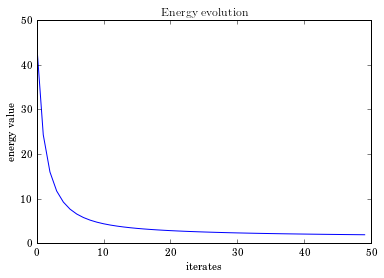

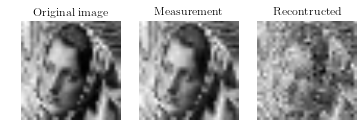

In [5]:
"""
Created on Tue Mar 13 09:15:34 2018

@author: alain_durmus
"""

import numpy as np
import matplotlib.pyplot as plt
from tp2_tools import *
import warnings
warnings.filterwarnings('ignore')
import time
#from ista import ista

lambda_l1 = 10 ** -2
n_it = 50
n = 32
r_sparse = 0.5
r_info = 1
y, A = noisy_observations(n, r_sparse, r_info)


def proxL1(x, gamma):
    eps = np.finfo(float).eps
    return np.fmax(0, 1 - gamma / np.fmax(eps, np.abs(x))) * x


def grad_f_1(x):
    Q = A.T.dot(A)
    Ay = A.T.dot(y)
    grad_f_x = Q.dot(x) - Ay
    Lip_grad_f = np.linalg.eigvalsh(Q).max()
    return grad_f_x, Lip_grad_f


def fun_total_1(x):
    return lambda_l1 * np.linalg.norm(x, ord=1) + (1. / 2) * np.linalg.norm(A.dot(x) - y)**2


dim = A.shape[1]

start_time = time.time()
x_final_ista, fun_iterate_ista = ista(
    dim, proxL1, grad_f_1, fun_total_1, lambda_l1, n_it)
elapsed_time = time.time() - start_time

energy_plt = plt.figure(1)
plt.plot(fun_iterate_ista)
plt.title(r'$\mathrm{Energy \ evolution}$')
plt.xlabel('iterates')
plt.ylabel('energy value')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
energy_plt.show()

images_plt = plt.figure('images')
images_plt.add_subplot(1, 3, 1)
plt.axis('off')
plt.imshow(load_image('barb.bmp', n), cmap='gray')
plt.title(r'$\mathrm{Original \ image}$')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
images_plt.add_subplot(1, 3, 2)
plt.axis('off')
plt.imshow(back_to_image(np.linalg.inv(A).dot(y)), cmap='gray')
plt.title(r'$\mathrm{Measurement}$')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
images_plt.add_subplot(1, 3, 3)
plt.axis('off')
plt.imshow(back_to_image(x_final_ista), cmap='gray')
plt.title(r'$\mathrm{Recontructed}$')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
images_plt.show()

print("||Ax-y||=", np.linalg.norm(A.dot(x_final_ista) - y))
print("Elapsed time=", elapsed_time, 's')

plt.show()

# Minimisation de la fonction $\max$
<a id="max"></a>

On commence par introduire les fonctions et générer les données.

In [6]:
lambda_max = 1
y, A = noisy_observation_inf()

Comme précédemment on a $\nabla f(x) = 2A^T(Ax- y)$.

On va poser la fonction $F_x(y) = \underset{i \in \lbrace 1,d \rbrace}{\max}(y_i) + (2\gamma)^{-1}( y-x)^2$ et $G_x(y,t) = t + (2\gamma)^{-1}( y- x)^2$.
Sur $C = \left\lbrace (y,t) \in \mathbb{R}^d, t \in \mathbb{R}, t\ge y \right\rbrace$ on a 
\begin{equation}\forall (y,t) \in C, G_x(y,t) \ge G(y, \underset{i \in \lbrace 1,d \rbrace}{\max}(y_i)) = F_x(y).\end{equation}
Ainsi
\begin{equation}
\underset{(y,t) \in C}{\min}G_x(y,t) \ge \underset{y \in \mathbb{R}^d}{\min} F_x(y) = \underset{(y,t) \in C}{\min}G(y,\underset{i \in \lbrace 1,d \rbrace}{\max}(y_i)) \ge \underset{(y,t) \in C}{\min}G_x(y,t),
\end{equation}
et l'égalité entre tous ces termes découle.
On définit le **Lagrangien**
\begin{equation}
\mathcal{L}(y,t,\Lambda) = t + (2\gamma)^{-1} \| y - x\|^2 + \langle \Lambda, y-t \mathbf{1}_d\rangle.
\end{equation}
Les conditions Karush-Kuhn-Tucker, *KKT*, assure que
\begin{equation}
\exists \Lambda^* \in \left(\mathbb{R}_+\right)^d, \nabla_{y,t} \mathcal{L}(y^*,t^*, \Lambda^*) = 0 \quad \text{ et } \quad t^{*} \geq \max_{i \in \{1,\ldots,d\}} y_i^* ,
\end{equation}
avec $(y^*,t^*)$ solution du **problème primal**.
En écrivant les équations on obtient que $\Lambda^*$ doit vérifier les équations suivantes
\begin{equation}
\left\lbrace
\begin{aligned}
 & \underset{i=1}{\overset{n}{\sum}} \lambda^*_i = 1 \\
 & \Lambda^* = \gamma^{-1}(x-y^*)
\end{aligned}
\right. .
\end{equation}
De plus les contraintes sont qualifiées donc $\forall i \in \lbrace 1,\ldots, d \rbrace,  \lambda_i^*(y_i^* - t^*) = 0$ et $\lambda^*_i \ge 0$. Cela implique que si $y_i^* < x_i$ alors $y_i^* = t^*$ et sinon on a $\lambda_i = 0 = (x_i-t^*)_+$ comme $t^{*} \geq \max_{i \in \{1,\ldots,d\}} y_i$. Ainsi on obtient
\begin{equation}
\left\lbrace
\begin{aligned}
 & \underset{i=1}{\overset{n}{\sum}} \lambda^*_i = 1 \\
 & \Lambda^* =  \gamma^{-1}\left (x-t^*\mathbf{1}_d\right)_+ .
\end{aligned}
\right.
\end{equation}
On a donc $t^*$ qui est solution de $g(t) = 0$
\begin{equation}
g(t) := -1 + \gamma^{-1} \underset{i=1}{\overset{d}{\sum}}  \left(x_i - t\right)_+ .
\end{equation}
C'est un problème unidimensionnel, décroissant qui admet une unique solution. On peut le résoudre par dichotomie.

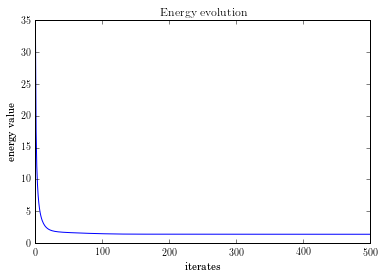

In [7]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 13 14:37:58 2018

@author: alain_durmus
"""


import numpy as np
import matplotlib.pyplot as plt
from tp2_tools import *
import warnings
warnings.filterwarnings('ignore')

lambda_max = 1
y, A = noisy_observation_inf()


def prox_max(v, gamma):
    tol = 1e-8
    max_iter = 1e2
    rho = 1 / gamma

    n = len(v)
    t_low = np.min(v)
    t_up = np.max(v)

    def g(t):
        return (np.sum(np.fmax(0, rho * (v - t))) - 1)

    iteration = 0

    while (t_up - t_low > tol) & (iteration <= max_iter):
        t0 = (t_up + t_low) / 2
        if np.sign(g(t0)) == np.sign(g(t_low)):
            t_low = t0
        else:
            t_up = t0
        iteration = iteration + 1
    return np.fmin(t0, v)


def grad_f_1(x):
    Q = A.T.dot(A)
    Ay = A.T.dot(y)
    grad_f_x = Q.dot(x) - Ay
    Lip_grad_f = np.linalg.eigvalsh(Q).max()
    return grad_f_x, Lip_grad_f


def fun_total_1(x):
    return lambda_max * np.max(x) + (1. / 2) * np.linalg.norm(A.dot(x) - y)**2


dim = A.shape[1]

x_final_ista, fun_iterate_ista = ista(
    dim, prox_max, grad_f_1, fun_total_1, lambda_max, n_it=500)

plt.figure()
plt.plot(fun_iterate_ista)
plt.title(r'$\mathrm{Energy \ evolution}$')
plt.xlabel('iterates')
plt.ylabel('energy value')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.show()

# Complétion de matrice de faible rang
<a id="completion"></a>

## Norme de Schatten
<a id ="schatten"></a>

On définit la **p-norme de Schatten** par 
\begin{equation}
\forall M \in \mathcal{M}_d(\mathbb{R}), \| M \|_{S,p} = \left( \underset{i=1}{\overset{d}{\sum}} \vert \sigma_i \vert^p \right)^{\frac{1}{p}},
\end{equation}
avec $(\sigma_i)_{i \in \lbrace 1,d \rbrace}$ la collection des **valeurs singulières** de $M$. Les **p-normes de Schatten** sont effectivement des normes matricielles dès que $p \ge 1$.
La **norme de Ky-Fan** est la 1-norme de Schatten. On l'appelle encore **norme nucléaire** et on la note $\| \cdot \|_*$. Elle possède des propriétés particulières (sa norme duale est la $\infty$-norme de Schatten, i.e la norme d'opérateur sur les matrices). On va montrer ici ce cas particulier de dualité. Soit $X \in \mathcal{M}_d(\mathbb{R})$. $X = O_1 \Sigma O_2$ sa décomposition en valeurs singulières. Notons $X^* = O_1 \operatorname{sign}(\Sigma) O_2$. Alors les valeurs singulières de $X^*$ sont majorées par $1$. Donc $\vert \vert \vert X^* \vert \vert \vert \le 1$.
\begin{equation}
\langle X, X^* \rangle = \operatorname{Tr} \left( O_2^T  \Sigma  O_1^T O_1 \operatorname{sign}(\Sigma) O_2 \right) = \| X \|_*.
\end{equation}
On a donc 
\begin{equation}
\underset{V, \vert \vert \vert V \vert \vert \vert \le 1}{\sup} \langle X,V \rangle \ge \| X \|_* .
\end{equation}
Dans l'autre sens,
\begin{equation}
\begin{aligned}
\underset{V, \vert \vert \vert V \vert \vert \vert \le 1}{\sup} \langle X,V \rangle &= \underset{V, \vert \vert \vert V \vert \vert \vert \le 1}{\sup} \operatorname{Tr} \left( \Sigma O_1^T V O_2\right)
 \\
&=\underset{V, \vert \vert \vert V \vert \vert \vert \le 1}{\sup} \underset{i=1}{\overset{n}{\sum}} \sigma_i \left( O_1^T V O_2\right)_{ii} \\
&=\underset{V, \vert \vert \vert V\vert \vert \vert \le 1}{\sup} \underset{i=1}{\overset{n}{\sum}} \sigma_i \left(O_1^T\right)_i V \left(O_2\right)_i \\
&\le \| X \|_*.
\end{aligned}
\end{equation}
On en déduit l'égalité voulue.

In [8]:
lambda_nuclear = 1
Y, A = noisy_observation_nuclear()

Calculons le gradient de $X \mapsto \|  A \circ X - Y \|^2$. En observant le comportement composante par composante on obtient
\begin{equation}
\begin{aligned}
\nabla f(X) &= A \circ \left( A \circ X - Y\right) \\
&= A \circ \left(X- Y\right).
\end{aligned}
\end{equation}
On va désormais montrer qu'un problème de minimisation faisant intervenir des normes de Schatten peut en fait se résoudre comme un problème vectoriel en utilisant la décomposition en valeurs singulières. On va utiliser l'invariance, élémentaire mais crucial, des normes de Schatten par isométrie. Cette invariance provient de l'invariance des valeurs singulières par isométrie.

\begin{equation}
\begin{aligned}
\underset{Y \in \mathcal{M}_d(\mathbb{R})}{\min} \|Y\|_* + (2\gamma)^{-1} \| Y - X \|_2^2 &=  \underset{Y \in \mathcal{M}_d(\mathbb{R})}{\min} \|Y\|_* + (2\gamma)^{-1} \| Y - O_1 \Sigma 0_2 \|_2^2 \\
&=\underset{O_1YO_2 \in \mathcal{M}_d(\mathbb{R})}{\min} \|O_1YO_2\|_* + (2\gamma)^{-1} \| O_1(Y - \Sigma)O_2 \|_2^2 \\
&=\underset{O_1YO_2 \in \mathcal{M}_d(\mathbb{R})}{\min} \|Y\|_* + (2\gamma)^{-1} \| Y - \Sigma\|_2^2 \\
&=\underset{Y\in \mathcal{M}_d(\mathbb{R})}{\min} \|Y\|_* + (2\gamma)^{-1} \| Y - \Sigma\|_2^2 
\end{aligned}
\end{equation}
Soit $O_1' Y O_2' = \Sigma_Y$ a les mêmes valeurs singulières que $Y$ et vérifie 
\begin{equation}
\| \Sigma_Y - D \|_2^2 \le \|Y - D \|_2^2.
\end{equation}
Ainsi on a 
\begin{equation}
\underset{Y\in \mathcal{M}_d(\mathbb{R})}{\min} \|Y\|_* + (2\gamma)^{-1} \| Y - \Sigma\|_2^2 \ge \underset{D\in \operatorname{diag}(\mathbb{R}^d)}{\min} \|D\|_* + (2\gamma)^{-1} \| D - \Sigma\|_2^2.
\end{equation}
L'autre inégalité est triviale. On résout le problème sur $D$ et on remonte à $Y$ en considérant $O_1 D O_2$.
On a donc prouvé que pour calculer l'opérateur proximal de la norme nucléaire il suffit de connaître l'opérateur proximal de la norme $\ell^1$, i.e
\begin{equation}
\operatorname{prox}_{\| \cdot \|_*}^{\gamma}(X) = O_1 \operatorname{prox}_{\ell^1}^{\gamma}(\Sigma) O_2.
\end{equation}

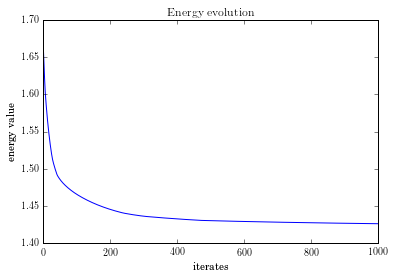

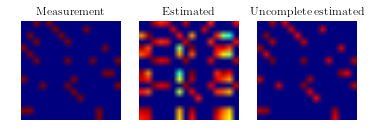

In [9]:
"""
Created on Tue Mar 13 16:19:57 2018

@author: alain_durmus
"""


import numpy as np
import matplotlib.pyplot as plt
from tp2_tools import *
import warnings
warnings.filterwarnings('ignore')

lambda_nuclear = 10 ** -1
Y, A = noisy_observation_nuclear()


def proxL1(x, gamma):
    eps = np.finfo(float).eps
    return np.fmax(0, 1 - gamma / np.fmax(eps, np.abs(x))) * x


def prox_nuclear(X, gamma):
    u, s, vh = np.linalg.svd(X)
    s_prox = proxL1(s, gamma)
    return u.dot(np.diag(s_prox).dot(vh))


def grad_f_1(X):
    grad_f_x = A * X - A * Y
    Lip_grad_f = 1
    return grad_f_x, Lip_grad_f


def fun_total_1(X):
    return lambda_nuclear * np.linalg.norm(X, ord='nuc') + (1. / 2) * np.linalg.norm(Y - A * X)**2


dim_1 = A.shape[0]
dim_2 = A.shape[1]

x_final_ista, fun_iterate_ista = ista_mat(
    dim_1, dim_2, prox_nuclear, grad_f_1, fun_total_1, lambda_nuclear, n_it=1000)

energy_plt = plt.figure()
plt.plot(fun_iterate_ista)
plt.title(r'$\mathrm{Energy \ evolution}$')
plt.xlabel('iterates')
plt.ylabel('energy value')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
energy_plt.show()

matrix_plt = plt.figure()
matrix_plt.add_subplot(1, 3, 1)
plt.axis('off')
plt.imshow(Y)
plt.title(r'$\mathrm{Measurement}$')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matrix_plt.add_subplot(1, 3, 2)
plt.axis('off')
plt.imshow(x_final_ista)
plt.title(r'$\mathrm{Estimated}$')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matrix_plt.add_subplot(1, 3, 3)
plt.axis('off')
plt.imshow(A * x_final_ista)
plt.title(r'$\mathrm{Uncomplete \ estimated}$')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matrix_plt.show()

plt.show()